In [1]:
import itertools
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import time
import pandas as pd

from scipy.stats import binom, norm
from math import comb

In [2]:
K_true = 3
M_true = np.array([4, 4, 4])

P_true = np.array([0.25, 0.35, 0.4])
Q_true = np.array([0.5, 0.5, 0.5])


X_param_true = np.array([[-5, 1.5],
                         [2, 1.6],
                         [7, 2.2]])


Y_param_true = np.array([[[-1, 0.5], [5, 1.5], [9, 0.5], [12, 0.8]],
                         [[-2, 0.5], [8, 0.9], [12, 0.8], [16, 0.8]],
                         [[-2, 0.5], [7, 0.9], [13, 0.8], [17, 0.8]]])

In [3]:
def generate_data():
    # Choose idx of mixture on X
    i = np.random.choice(K_true, p=P_true)

    # Choose amount of latent variables in this mixture
    eta = 1 + np.random.binomial(n=M_true[i]-1, p=Q_true[i])

    # Choose mixture latent variable
    l = np.random.choice(a=eta)

    x = np.random.normal(X_param_true[i, 0], np.sqrt(X_param_true[i, 1]))
    y = np.random.normal(Y_param_true[i, l][0], np.sqrt(Y_param_true[i, l][1]))

    return x, y, np.sum(M_true[:i]) + l

In [4]:
def generate_dataset(n_samples, random_state=42):
    np.random.seed(random_state)

    data = []
    labels = []


    for _ in range(n_samples):
        x, y, label = generate_data()
        data.append(np.array([x, y]))
        labels.append(label)

    return np.array(data), np.array(labels)

In [5]:
data, labels = generate_dataset(500)

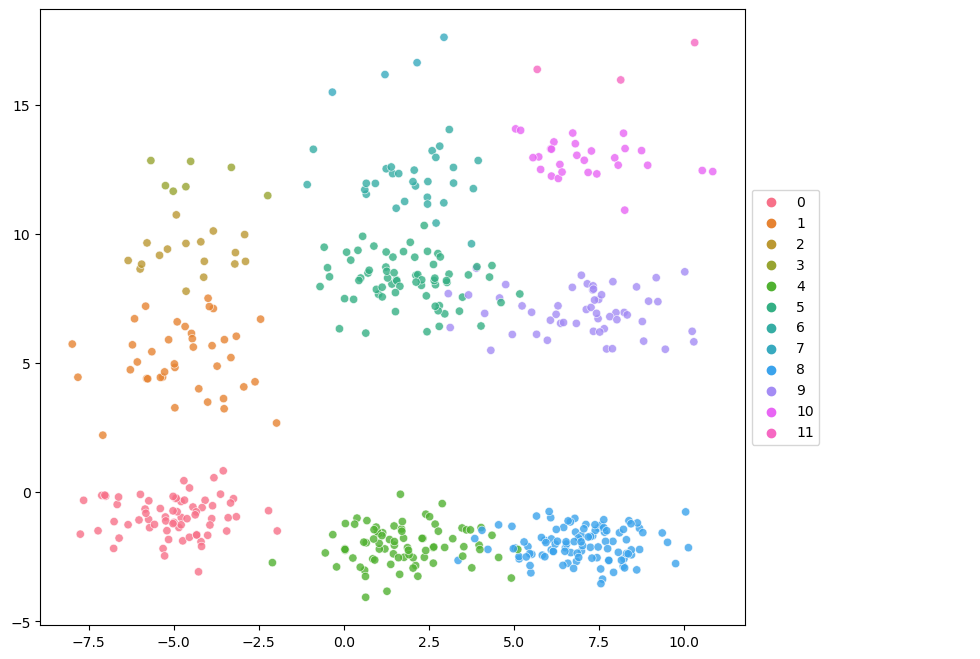

In [6]:
fig = plt.figure(figsize=(12, 8))
grid = plt.GridSpec(1, 2, width_ratios=[5, 1])
# Use Seaborn's "husl" palette for n colors
custom_palette = sns.color_palette("husl", len(np.unique(labels)))  

# Create the scatterplot on the left side
ax1 = plt.subplot(grid[0, 0])
scatter = sns.scatterplot(x=data[:, 0], y=data[:, 1], alpha=0.8, hue=labels, ax=ax1, palette=custom_palette)

# Create a separate axis for the legend on the right side
ax2 = plt.subplot(grid[0, 1])
ax2.axis('off')  # Hide the axis for the legend
legend = ax1.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [7]:
class EMModel:
    def __init__(self):
        self.denominator_pi = None

        self.K = None
        # M - array
        self.M = None
        self.P = None
        # Q - matrix
        self.Q = None
        self.X_param = None
        self.Y_param = None

        self.current_likelihood_ = None
    


    def fit(self, data, M, P, Q, X_param, Y_param, epochs):
        n = data.shape[0]
        self.K = P.shape[0]
        self.M = np.copy(M)
        self.P = np.copy(P)
        self.Q = np.copy(Q)
        self.X_param = np.copy(X_param)
        self.Y_param = np.copy(Y_param)

        
        resp_shape = (n, self.K, np.max(self.M), np.max(self.M))
        responsibilities = np.zeros(resp_shape, dtype=np.longdouble)

        start_time = time.time()

        self.current_likelihood_ = np.zeros(epochs)
        for epoch in range(epochs):
            print("Epoch:", epoch)
            # E-Step
            # Calculate responsibilities 

            for t, (x, y) in enumerate(data):
                for i in range(0, self.K):
                    for j in range(1, self.M[i] + 1):
                        for l in range(0, j):
                            responsibilities[t, i, j - 1, l] = self.calculate_responsb_(x, y, i, j, l)

                
                s_t = np.sum(responsibilities[t, :, :, :])
                responsibilities[t, :, :, :] /= s_t
                self.current_likelihood_[epoch] += np.log(s_t)
        

            print("E-Step done")
            end_time = time.time()
            print(f"Time elapsed: {end_time - start_time} seconds")
        

            # M-Step
            # Update parameters

            # Update P
            for i in range(self.K):
                self.P[i] = np.sum(responsibilities[:, i, :, :]) / n

            # Update Q
            for i in range(self.K):
                for j in range(0, self.M[i]):
                    self.Q[i, j] = np.sum(responsibilities[:, i, j, :])
                self.Q[i, :] /= np.sum(self.Q[i, :])

            
            # Update mean for X
            for i in range(self.K):
                res = 0
                for t in range(n):
                    res += np.sum(responsibilities[t, i, :, :]) * data[t, 0]
                self.X_param[i, 0] = res / np.sum(responsibilities[:, i, :, :])
            
            # Update variance for X
            for i in range(self.K):
                res = 0
                for t in range(n):
                    res += np.sum(responsibilities[t, i, :, :]) * (data[t, 0] - self.X_param[i, 0])**2
                self.X_param[i, 1] = res / np.sum(responsibilities[:, i, :, :])
            
            
            # Update mean for Y
            for i in range(self.K):
                for l in range(self.M[i]):

                    res = 0
                    for j in range(self.M[i]):
                        for t in range(n):
                            res += responsibilities[t, i, j, l] * data[t, 1]

                    self.Y_param[i, l, 0] = res / np.sum(responsibilities[:, i, :, l]) 

            
            # Update variance for Y
            for i in range(self.K):
                for l in range(self.M[i]):

                    res = 0
                    for j in range(self.M[i]):
                        for t in range(n):
                            res += responsibilities[t, i, j, l] * (data[t, 1] - self.Y_param[i, l, 0])**2

                    self.Y_param[i, l, 1] = res / np.sum(responsibilities[:, i, :, l])
            
            print("M-step done")

            print("Current log likelihood:", self.current_likelihood_[epoch])
            print("P:\n", self.P)
            print("Q:\n", self.Q)
            print("X_param\n", self.X_param)
            print("Y_param\n", self.Y_param)

    def calculate_pi_(self, i, j, l):
        return self.P[i] * self.Q[i, j-1] / j


    def calculate_responsb_(self, x, y, i, j, l):
        res = self.calculate_pi_(i, j, l) * \
            norm.pdf(x, loc=self.X_param[i,0], scale=np.sqrt(self.X_param[i,1])) * \
            norm.pdf(y, loc=self.Y_param[i, l][0], scale=np.sqrt(self.Y_param[i,l][1]))
        
        return res

In [8]:
def generate_est_parameters(data, random_state):
    np.random.seed(random_state)

    # Estimate P
    P_est = np.full(K_true, 1/K_true)
    noise = np.random.dirichlet(np.ones(K_true))
    P_est += noise * 0.05
    P_est /= np.sum(P_est)

    # Estimate Q
    Q_est = np.zeros(shape=(K_true, np.max(M_true)))
    for i in range(K_true):
        Q_est[i, :M_true[i]] = np.ones(M_true[i]) / M_true[i]
        noise = np.random.dirichlet(np.ones(M_true[i]))
        Q_est[i, :M_true[i]] += noise * 0.05
        Q_est[i, :M_true[i]] /= np.sum(Q_est[i])

    
    # Estimate X, Y
    X_param_est = np.zeros((K_true, 2))
    Y_param_est = np.zeros((K_true, np.max(M_true), 2))

    min_x = np.min(data[:, 0])
    max_x = np.max(data[:, 0])
    intervals = np.linspace(min_x, max_x, K_true + 1)

    for i in range(0, K_true):
        X_param_est[i][0] = np.random.uniform(intervals[i], intervals[i+1])
        X_param_est[i][1] = np.random.uniform(0, (intervals[i+1] - intervals[i])/6)
    
    min_y = np.min(data[:, 1])
    max_y = np.max(data[:, 1])

    intervals = []
    for i in range(K_true):
        intervals.append(np.linspace(min_y, max_y, M_true[i] + 1))

    for i in range(0, K_true):
        for j in range(0, M_true[i]):
            Y_param_est[i, j, 0] = np.random.uniform(intervals[i][j], intervals[i][j + 1])
            Y_param_est[i, j, 1] = np.random.uniform(0, (intervals[i][j + 1] - intervals[i][j])/6)

    return P_est, Q_est, X_param_est, Y_param_est

In [25]:
def q_to_matrix(Q):
    # Suppose Q is 1d array

    Q_matrix = np.zeros((K_true, np.max(M_true)))
    
    for i in range(0, K_true):
        for j in range(1, M_true[i] + 1):
            Q_matrix[i, j-1] = binom.pmf(k=j-1, n=M_true[i]-1, p=Q[i])
    
    return Q_matrix

In [10]:
P_est, Q_est, X_param_est, Y_param_est = generate_est_parameters(data, 15)

In [11]:
P_est

array([0.35945556, 0.32184164, 0.31870281])

In [12]:
Q_est

array([[0.2493941 , 0.24620718, 0.25710798, 0.24729074],
       [0.24338969, 0.23982306, 0.24228818, 0.27449906],
       [0.24089061, 0.24962439, 0.25639349, 0.2530915 ]])

In [13]:
X_param_est

array([[-6.66500355,  0.1750505 ],
       [-1.41386118,  0.04126268],
       [ 5.83038789,  1.04515879]])

In [14]:
Y_param_est

array([[[-2.04485771,  0.68711111],
        [ 3.92188289,  0.46052113],
        [11.89911601,  0.09888362],
        [14.71829207,  0.12789333]],

       [[-1.14736024,  0.27014139],
        [ 4.27028974,  0.6013858 ],
        [ 8.75113463,  0.5628892 ],
        [15.68121974,  0.3794481 ]],

       [[-1.87976106,  0.35273967],
        [ 3.5571366 ,  0.07197729],
        [ 7.08421421,  0.07077095],
        [15.96827341,  0.02634474]]])

In [15]:
M_true

array([4, 4, 4])

In [16]:
model = EMModel()
res = model.fit(data, M_true, P_est, Q_est, X_param_est, Y_param_est, epochs=25)

Epoch: 0
E-Step done
Time elapsed: 4.1070122718811035 seconds
M-step done
Current log likelihood: -14319.271698260363
P:
 [0.23760862 0.078621   0.68377039]
Q:
 [[0.26432905 0.28925677 0.25933743 0.18707675]
 [0.06736964 0.08084395 0.42001879 0.43176762]
 [0.24781083 0.1283985  0.30800158 0.31578908]]
X_param
 [[-5.03971843  1.21055896]
 [-0.5274662   2.90655856]
 [ 4.82968121  7.8807867 ]]
Y_param
 [[[-9.33168611e-01  5.64694774e-01]
  [ 5.81633247e+00  3.04231431e+00]
  [ 1.10927294e+01  1.63017251e+00]
  [ 1.28343543e+01  2.86871254e-04]]

 [[-1.72388526e+00  5.18316284e-01]
  [ 4.42460915e+00  1.76110904e+00]
  [ 1.04978914e+01  2.54023292e+00]
  [ 1.37973748e+01  1.56955816e+00]]

 [[-2.03156757e+00  4.38005280e-01]
  [ 5.45579833e+00  7.51780341e-02]
  [ 8.16845192e+00  3.06753565e+00]
  [ 1.39593867e+01  2.10231126e+00]]]
Epoch: 1
E-Step done
Time elapsed: 7.806828260421753 seconds
M-step done
Current log likelihood: -2715.998878552632
P:
 [0.24106319 0.07758783 0.68134898]
Q:
 

In [17]:
model.current_likelihood_

array([-14319.27169826,  -2715.99887855,  -2661.08431699,  -2621.36368024,
        -2591.34715735,  -2567.46185605,  -2552.00354648,  -2542.90469387,
        -2536.29280889,  -2531.31115636,  -2527.77535076,  -2524.9190386 ,
        -2522.31147221,  -2519.81356556,  -2517.39900134,  -2515.08055576,
        -2512.89714387,  -2510.91876176,  -2509.21613146,  -2507.81790534,
        -2506.70799589,  -2505.84739068,  -2505.19111428,  -2504.69622804,
        -2504.32506587])

In [18]:
y_vals = model.current_likelihood_

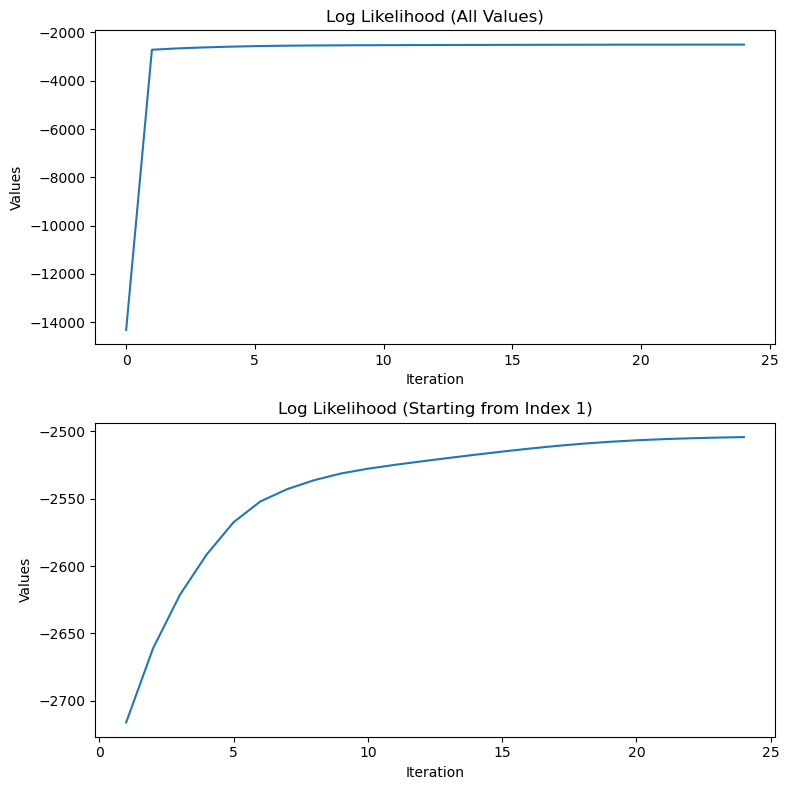

In [19]:
fig, axis = plt.subplots(2, 1, figsize=(8, 8))

ax = axis[0]

ax.plot(np.arange(len(y_vals)), y_vals)
ax.set_title('Log Likelihood (All Values)')
ax.set_xlabel('Iteration')
ax.set_ylabel('Values')


ax = axis[1]
ax.plot(np.arange(1, len(y_vals)), y_vals[1:])
ax.set_title('Log Likelihood (Starting from Index 1)')
ax.set_xlabel('Iteration')
ax.set_ylabel('Values')

plt.tight_layout();

In [20]:
P_true

array([0.25, 0.35, 0.4 ])

In [21]:
model.P

array([0.26275125, 0.34091264, 0.39633611])

In [22]:
Q_true

array([0.5, 0.5, 0.5])

In [26]:
q_to_matrix(Q_true)

array([[0.125, 0.375, 0.375, 0.125],
       [0.125, 0.375, 0.375, 0.125],
       [0.125, 0.375, 0.375, 0.125]])

In [27]:
model.Q

array([[0.2199012 , 0.26198999, 0.45630327, 0.06180554],
       [0.16292519, 0.04933644, 0.44502245, 0.34271592],
       [0.40437388, 0.00950237, 0.04607158, 0.54005217]])

In [30]:
X_param_true

array([[-5. ,  1.5],
       [ 2. ,  1.6],
       [ 7. ,  2.2]])

In [29]:
model.X_param

array([[-4.80846968,  1.62270773],
       [ 1.73923507,  1.51666118],
       [ 6.89805116,  2.52920392]])

In [31]:
Y_param_true

array([[[-1. ,  0.5],
        [ 5. ,  1.5],
        [ 9. ,  0.5],
        [12. ,  0.8]],

       [[-2. ,  0.5],
        [ 8. ,  0.9],
        [12. ,  0.8],
        [16. ,  0.8]],

       [[-2. ,  0.5],
        [ 7. ,  0.9],
        [13. ,  0.8],
        [17. ,  0.8]]])

In [32]:
model.Y_param

array([[[-9.52411248e-01,  5.70497081e-01],
        [ 5.13854495e+00,  1.79607713e+00],
        [ 9.67035476e+00,  2.12173236e+00],
        [ 1.28291528e+01,  2.38760737e-04]],

       [[-2.04894796e+00,  5.34323967e-01],
        [ 8.21980916e+00,  4.23341456e-01],
        [ 1.02142510e+01,  4.95528854e+00],
        [ 1.25506822e+01,  7.85452682e+00]],

       [[-2.02239270e+00,  3.69673825e-01],
        [ 6.41857572e+00,  3.00152840e-01],
        [ 7.60739065e+00,  3.10190554e-01],
        [ 1.32518607e+01,  1.58376517e+00]]])